In [1]:
from __future__ import print_function
import urllib
import bz2
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import matplotlib.image as mpimg
import cv2
import plotly.graph_objs as go
import os
from utils.utils_IO import ordered_arr_3d_to_dict, refill_nan_array, arr_2d_to_list_of_dicts, read_image, make_image_array, revert_ordered_arr_2d_to_dict, save_object, write_video
from utils.utils_plotting import plot_image_labels, plot_3d_points, vector_plot, draw_circles, slope, drawLine, skew, plot_cams_and_points
from utils.utils_BA import fun, bundle_adjustment_sparsity, project
from anipose_BA import CameraGroup, Camera
from scipy.spatial.transform import Rotation as R
%load_ext autoreload
%autoreload 2

# Load and process data

In [2]:
TOP_IMG_HEIGHT=168
BOT_IMG_HEIGHT=238
IMG_WIDTH= 396
P_X_BOT = P_X_TOP = IMG_WIDTH // 2
P_Y_BOT = BOT_IMG_HEIGHT // 2
P_Y_TOP = TOP_IMG_HEIGHT // 2
#(Camera, Coordinates)
#OFFSET = np.asarray([[P_Y_TOP, P_X_TOP], [P_Y_BOT, P_X_BOT]])
OFFSET = np.asarray([[P_X_TOP, P_Y_TOP], [P_X_BOT, P_Y_BOT]])

In [3]:
data_folder = './mouseRunningData'

In [4]:
DLC_dframe = pd.read_csv(data_folder + '/CollectedData_.csv', 
                         header = [1,2]) 
# header = [1,2] is important. Provides a hierarchical data frame
DLC_dframe.head() # inspect
#DLC_dframe['paw1LH_top','x'] # that's how you index.

bodyparts paw1LH_top         paw2LF_top              \
                         coords          x       y          x           y   
0  barObstacleScaling1/img1.png      77.25   36.25     253.50  101.900393   
1  barObstacleScaling1/img2.png      37.25  110.75     285.75  104.750000   
2  barObstacleScaling1/img3.png     123.25  110.25     325.25  114.750000   
3  barObstacleScaling1/img4.png     125.25  106.75     230.25   51.250000   
4  barObstacleScaling1/img5.png      67.75   98.25     269.75  103.250000   

  paw3RF_top         paw4RH_top         tailBase_top  ... tailBase_bot  \
           x       y          x       y            x  ...            x   
0     198.75   97.75     182.25   63.75          NaN  ...        84.75   
1     253.25  101.75      46.75  129.75        49.25  ...        54.25   
2     279.25  103.25      39.75  143.75          NaN  ...        74.75   
3     317.75  113.25      70.25  123.25        55.75  ...        77.25   
4     305.75   96.25      29.25   72.75        65.25  ...        82.75   

          tailMid_bot         nose_bot         obsHigh_bot         obsLow_bot  \
        y           x       y        x       y           x       y          x   
0  329.75       46.25  332.75   381.25  281.75       74.25  184.25      74.75   
1  304.75       27.25  313.75   382.25  282.25      121.25  184.75     118.75   
2  318.25       34.75  389.75   383.25  280.75      236.25  198.25     234.75   
3  309.75       32.75  317.75   383.25  280.25      222.25  198.75     213.75   
4  323.25       35.75  339.25   381.75  280.25      116.25  192.25     112.25   

           
        y  
0  386.25  
1  385.75  
2  381.75  
3  380.25  
4  381.25  

[5 rows x 35 columns]

In [5]:
# change the bodyparts, coords entries.
DLC_dframe = DLC_dframe.rename(columns = { \
    "bodyparts":"img_name", "coords":"img_name" })
DLC_dframe.head()

img_name paw1LH_top         paw2LF_top              \
                       img_name          x       y          x           y   
0  barObstacleScaling1/img1.png      77.25   36.25     253.50  101.900393   
1  barObstacleScaling1/img2.png      37.25  110.75     285.75  104.750000   
2  barObstacleScaling1/img3.png     123.25  110.25     325.25  114.750000   
3  barObstacleScaling1/img4.png     125.25  106.75     230.25   51.250000   
4  barObstacleScaling1/img5.png      67.75   98.25     269.75  103.250000   

  paw3RF_top         paw4RH_top         tailBase_top  ... tailBase_bot  \
           x       y          x       y            x  ...            x   
0     198.75   97.75     182.25   63.75          NaN  ...        84.75   
1     253.25  101.75      46.75  129.75        49.25  ...        54.25   
2     279.25  103.25      39.75  143.75          NaN  ...        74.75   
3     317.75  113.25      70.25  123.25        55.75  ...        77.25   
4     305.75   96.25      29.25   72.75        65.25  ...        82.75   

          tailMid_bot         nose_bot         obsHigh_bot         obsLow_bot  \
        y           x       y        x       y           x       y          x   
0  329.75       46.25  332.75   381.25  281.75       74.25  184.25      74.75   
1  304.75       27.25  313.75   382.25  282.25      121.25  184.75     118.75   
2  318.25       34.75  389.75   383.25  280.75      236.25  198.25     234.75   
3  309.75       32.75  317.75   383.25  280.25      222.25  198.75     213.75   
4  323.25       35.75  339.25   381.75  280.25      116.25  192.25     112.25   

           
        y  
0  386.25  
1  385.75  
2  381.75  
3  380.25  
4  381.25  

[5 rows x 35 columns]

In [6]:
bodyparts = list(DLC_dframe.columns.levels[0][1:]) # [1:] to remove img name

In [7]:
import re 

def sorted_nicely( l ): 
    """ Sort the given iterable in the way that humans expect.""" 
    convert = lambda text: int(text) if text.isdigit() else text 
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ] 
    return sorted(l, key = alphanum_key)
    

In [8]:
from pathlib import Path

path_images = data_folder + \
                '/' + \
                DLC_dframe["img_name", "img_name"]\
                .to_numpy()


path_images_1 = sorted_nicely(os.listdir(Path(data_folder) / 'camera1Images/'))
path_images_1 = [str(Path(data_folder).resolve() / Path('camera1Images/') / i) for i in path_images_1]

path_images_2 = sorted_nicely(os.listdir(Path(data_folder) / 'camera2Images/'))
path_images_2 = [str(Path(data_folder).resolve() / Path('camera2Images/') / i) for i in path_images_2]

path_images = [path_images_1, path_images_2]

In [9]:
# pick either all body parts or part of them
#bp2plot = ['nose_bot', 'nose_top', 'tailBase_bot', 'tailBase_top']
bp2plot = bodyparts
pose_2D_dict = {}
pose_2D_dict["x_coords"] = DLC_dframe.loc[: , (bp2plot , 'x')].to_numpy() # DLC_dframe[bp2plot]
pose_2D_dict["y_coords"] = DLC_dframe.loc[: , (bp2plot , 'y')].to_numpy() # DLC_dframe[bp2plot]

In [10]:
# using https://stackoverflow.com/questions/12897374/get-unique-values-from-a-list-in-python
'''just these body parts that are seen from both views.'''
bp2plot = bodyparts
bp_short = []
for i in range(len(bp2plot)):
    if bp2plot[i][:3] != 'obs': # not plotting the obstacle
        bp_short.append(bp2plot[i][:-4]) # last four chars (_top/_bot)

short_list = list(set(bp_short)) # set returns unique elements in list
short_list_bot = []
short_list_top = []
for i in short_list:
    short_list_bot.append(i + '_bot')
    short_list_top.append(i + '_top')
short_list_top.sort()
short_list_bot.sort()
tuple_x= (short_list_top, 'x')
tuple_y= (short_list_top, 'y')
tuple_z = (short_list_bot, 'y') #Remember to negate (right-hand-rule)

Normalizing / Re-mapping coordinates for bottom image

In [11]:
# Treat bottom image separately
# Remap y-values for bottom image
# NOTE: THIS IS ONLY BECAUSE'S THE 2 CAMERA VIEWS IN RICK'S DATA
#   COME AS A SINGLE IAMGE
#   SO, WE NEED TO SCALE THE POINTS ACCORDINGLY
DLC_dframe.loc[: , tuple_z] -= TOP_IMG_HEIGHT

In [12]:
# extract 3d from rick
pose_dict_3d = {}
pose_dict_3d["x_coords"] = DLC_dframe.loc[: , \
                            tuple_x].to_numpy() # DLC_dframe[bp2plot]
pose_dict_3d["y_coords"] = DLC_dframe.loc[: , \
                            tuple_y].to_numpy() #/ DLC_dframe[bp2plot]

pose_dict_3d["z_coords"] = - DLC_dframe.loc[: , \
                           tuple_z].to_numpy()  # DLC_dframe[bp2plot]

In [13]:
# transform to BA format
pts_array_3d = np.hstack([pose_dict_3d["x_coords"].flatten().reshape(-1,1), 
           pose_dict_3d["y_coords"].flatten().reshape(-1,1),
                         pose_dict_3d["z_coords"].flatten().reshape(-1,1)])

print('original number of unique pts was %d' % pts_array_3d.shape[0])
nan_pts_3d = np.isnan(pts_array_3d).any(axis=1) # remove 3d points here and in each view

original number of unique pts was 7315


In [14]:
# removing_nans
print('excluding %d tracked points!' % np.sum(nan_pts_3d==True)) # number of excluded 3d points.
pts_array_3d_clean = pts_array_3d[~nan_pts_3d, :]
pts_all_flat = np.arange(pts_array_3d.shape[0])
clean_point_indices = pts_all_flat[~nan_pts_3d]

#(clean_point_indices == np.where(~nan_pts_3d)).all() # True
info_dict = {}
info_dict["num_frames"] = DLC_dframe.shape[0]
info_dict["num_analyzed_body_parts"] = len(short_list)
info_dict["num_cameras"] = 2
info_dict["num_points_all"] = pts_array_3d.shape[0]
info_dict["clean_point_indices"] = pts_all_flat[~nan_pts_3d]
assert(info_dict["num_points_all"] == 
           info_dict["num_frames"]*info_dict["num_analyzed_body_parts"])

excluding 618 tracked points!


In [15]:
# extract params for BA. assuming all points are visible from the two cameras (even if nans)
# only body parts that are visible in both views
tuple_x_bot = (short_list_bot, 'x')
tuple_y_bot = (short_list_bot, 'y')
tuple_x_top = (short_list_top, 'x')
tuple_y_top = (short_list_top, 'y')

# hstack x,y
pts_array_2d_bot_full = np.hstack([DLC_dframe.loc[: , \
        tuple_x_bot].to_numpy().flatten().reshape(-1,1),
                             DLC_dframe.loc[: , \
        tuple_y_bot].to_numpy().flatten().reshape(-1,1)])

print(pts_array_2d_bot_full.shape)

# remove nan_pts_3d rows
pts_array_2d_bot = pts_array_2d_bot_full[~nan_pts_3d, :]

# hstack x,y, and remove nan_pts_3d rows.
pts_array_2d_top_full = np.hstack([DLC_dframe.loc[: , \
        tuple_x_top].to_numpy().flatten().reshape(-1,1),
                             DLC_dframe.loc[: , \
        tuple_y_top].to_numpy().flatten().reshape(-1,1)])

pts_array_2d_top = pts_array_2d_top_full[~nan_pts_3d, :]

print(tuple_x_top)

print('shape of each 2d pt array is %s and %s' %(
    str(pts_array_2d_bot.shape),
    str(pts_array_2d_top.shape)))

(7315, 2)
(['nose_top', 'paw1LH_top', 'paw2LF_top', 'paw3RF_top', 'paw4RH_top', 'tailBase_top', 'tailMid_top'], 'x')
shape of each 2d pt array is (6697, 2) and (6697, 2)


In [16]:
pts_array_2d = np.concatenate((pts_array_2d_top[np.newaxis,:,:], pts_array_2d_bot[np.newaxis,:,:]), axis=0)
pts_array_2d_og = np.reshape(pts_array_2d, (pts_array_2d.shape[0] * pts_array_2d.shape[1], -1))

array_2d_orig = refill_nan_array(pts_array_2d_og, 
                              info_dict, 
                               dimension = '2d')
                               
pose_list_2d_orig = arr_2d_to_list_of_dicts(array_2d_orig,
                                              info_dict)


# Requirements for Bundle Adjustment

`P_{X,Y}_{TOP,BOT}`: (int) - {width / 2, height / 2} for camera {1,2}

-->For setting the offset terms in the camera matrix to the center of the image plane


`pts_array_2d`: (np.array) - Array of shape (num_cameras, num_points, 2) containing set of 2d points for each camera. This should be after cleaning NaNs i.e. removing rows with NaNs

`info_dict`: Dictionary with keys {'num_frames', 'num_analyzed_body_parts', 'num_cameras', 'num_points_all', 'clean_point_indices'}

--> 'num_frames' is the number of frames in the video

--> 'num_analyzed_body_parts' is the number of body parts / joints being modeled (i.e. one per keypoint)

--> 'num_cameras' is the number of cameras. In our case, it is 2

--> 'num_points_all' is the original number of points (including NaNs)

--> 'clean_point_indices' is a list of indices (with length = num_points in `pts_array_2d`) pointing to the clean (non-NaN) entries in the original data

`path_images`: (list) - List of sublists. Each sublist (one per camera / view) contains absolute paths to image frames. 


In [17]:
import pickle
from pathlib import Path
def save_object(obj, filename, objects_dir='./rick_data_objects/'):
    with open(Path(objects_dir) / filename, 'wb') as output:  # Overwrites any existing file.
        pickle.dump(obj, output, pickle.HIGHEST_PROTOCOL)

def load_object(filename, objects_dir='./rick_data_objects/'):
    obj = None
    with open(Path(objects_dir) / filename, 'rb') as input:
        obj = pickle.load(input)
    return obj

In [18]:
'''
save_object(info_dict, 'info_dict.pkl')
save_object(pts_array_2d, 'pts_array_2d.pkl')
offsets = [P_X_TOP, P_Y_TOP, P_X_BOT, P_Y_BOT]
save_object(offsets, 'offsets.pkl')
save_object(path_images, 'path_images.pkl')
'''

"\nsave_object(info_dict, 'info_dict.pkl')\nsave_object(pts_array_2d, 'pts_array_2d.pkl')\noffsets = [P_X_TOP, P_Y_TOP, P_X_BOT, P_Y_BOT]\nsave_object(offsets, 'offsets.pkl')\nsave_object(path_images, 'path_images.pkl')\n"

In [19]:
'''
#Load
info_dict = load_object('info_dict.pkl')
pts_array_2d = load_object('pts_array_2d.pkl')
offsets = load_object('offsets.pkl')
path_images = load_object('path_images.pkl')
[P_X_TOP, P_Y_TOP, P_X_BOT, P_Y_BOT] = offsets
IMG_WIDTH = P_X_TOP * 2
TOP_IMG_HEIGHT = P_Y_TOP * 2
'''

"\n#Load\ninfo_dict = load_object('info_dict.pkl')\npts_array_2d = load_object('pts_array_2d.pkl')\noffsets = load_object('offsets.pkl')\npath_images = load_object('path_images.pkl')\n[P_X_TOP, P_Y_TOP, P_X_BOT, P_Y_BOT] = offsets\nIMG_WIDTH = P_X_TOP * 2\nTOP_IMG_HEIGHT = P_Y_TOP * 2\n"

# Bundle Adjust

In [20]:
#--------CAMERA 1------------
#Initialize camera 1
camera_1 = Camera(rvec=[0,0,0], tvec=[0,0,0])
#Set offset
camera_1.set_size((P_X_TOP, P_Y_TOP))

cam1_init_params = np.abs(np.random.rand(8))
#Set rotations [0:3] and translation [3:6] to 0
cam1_init_params[0:6] = 0
#Initialize focal length to image width
cam1_init_params[6] = P_X_TOP * 2
#Initialize distortion to 0
cam1_init_params[7] = 0.0 
#Set parameters
camera_1.set_params(cam1_init_params)

#--------CAMERA 2------------
#Set rotation vector w.r.t. camera 1
rvec2 = np.pi/2 * np.array([1, 0, 0])
#Set translation vector w.r.t. camera 1\
tvec2 = [0, 1, 1]
#Initialize camera 2
camera_2 = Camera(rvec=rvec2, tvec=tvec2)
#Set offset 
camera_1.set_size((P_X_BOT, P_Y_BOT))

cam2_init_params = np.abs(np.random.rand(8))
cam2_init_params[0:3] = rvec2
cam2_init_params[3:6] = tvec2
cam2_init_params[6] = P_X_BOT * 2
cam2_init_params[7] = 0.0
camera_2.set_params(cam2_init_params)

#Group cameras
cam_group = CameraGroup(cameras=[camera_1, camera_2])

In [21]:
#Get error before Bundle Adjustment by triangulating using the initial parameters:
f0, points_3d_init = cam_group.get_initial_error(pts_array_2d)
print(points_3d_init.shape)

(6697, 3)


In [22]:
fig = plot_cams_and_points(cam_group=cam_group, points_3d=points_3d_init, title="3D Points Initialized")

In [23]:
#Run Bundle Adjustment
res, points_3d = cam_group.bundle_adjust(pts_array_2d)

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.7083e+07                                    1.86e+08    
       1              2         1.5580e+06      1.55e+07       1.51e+02       1.76e+07    
       2              4         1.4730e+06      8.50e+04       2.06e+02       3.62e+07    
       3              5         4.6036e+05      1.01e+06       9.48e+00       1.74e+06    
       4              6         4.2335e+05      3.70e+04       5.27e+01       2.31e+06    
       5              7         3.8650e+05      3.69e+04       1.06e+02       7.64e+06    
       6              8         3.2740e+05      5.91e+04       1.11e+02       6.16e+06    
       7              9         2.8382e+05      4.36e+04       1.11e+02       5.67e+06    
       8             10         2.4933e+05      3.45e+04       1.11e+02       5.20e+06    
       9             11         2.2191e+05      2.74e+04       1.11e+02       4.88e+06    

In [24]:
fig = plot_cams_and_points(cam_group=cam_group, points_3d=points_3d, title="3D Points Bundle Adjusted")

In [25]:
#Get projected points
points_proj_1 = camera_1.project(points_3d, ).squeeze()
points_proj_2 = camera_2.project(points_3d).squeeze()
points_proj = np.concatenate((points_proj_1, points_proj_2), axis=0)
print('f_1: ', camera_1.get_focal_length())
print('f_2: ', camera_2.get_focal_length())
print('dist_1: ', camera_1.get_distortions())
print('dist_2: ', camera_2.get_distortions())


f_1:  1558.2803052542022
f_2:  1534.4176567360005
dist_1:  [0. 0. 0. 0. 0.]
dist_2:  [0. 0. 0. 0. 0.]


In [26]:
plot_folder = 'rick_plots'
if not os.path.exists(plot_folder):
    os.makedirs(plot_folder)

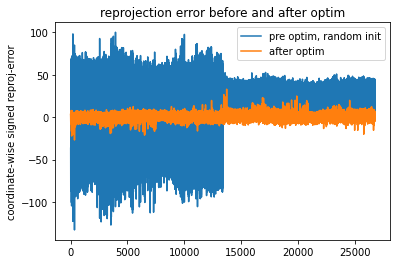

In [27]:
plt.plot(f0, label = 'pre optim, random init')
plt.plot(res.fun, label = 'after optim')
plt.legend()
plt.ylabel('coordinate-wise signed reproj-error')
plt.title('reprojection error before and after optim')
plt.savefig(os.path.join(plot_folder,'reproj-err-per-frame-initdlc3d.png'))

In [28]:
# now we first refill the full sized containers, then revert to dicts.

# do the pts_array_3d_clean
array_3d_back = refill_nan_array(points_3d, 
                               info_dict, 
                               dimension = '3d')
pose_dict_3d_refill = ordered_arr_3d_to_dict(array_3d_back, info_dict)

# pts_3d_BA
BA_array_3d_back = refill_nan_array(points_3d, 
                               info_dict, 
                               dimension = '3d')
BA_dict = ordered_arr_3d_to_dict(BA_array_3d_back, info_dict)

# pts_2d_orig
pts_array_2d_og = np.reshape(pts_array_2d, (pts_array_2d.shape[0] * pts_array_2d.shape[1], -1))
array_2d_orig = refill_nan_array(pts_array_2d_og, 
                              info_dict, 
                               dimension = '2d')
pose_list_2d_orig = arr_2d_to_list_of_dicts(array_2d_orig,
                                              info_dict)
                                              
# pts_2d_reproj
array_2d_reproj_back = refill_nan_array(points_proj, 
                              info_dict, 
                               dimension = '2d')
pose_list_2d_reproj = arr_2d_to_list_of_dicts(array_2d_reproj_back,
                                              info_dict)

In [29]:
joined_list_2d = pose_list_2d_orig + pose_list_2d_reproj
joined_list_3d = []
joined_list_3d.append(pose_dict_3d_refill)
joined_list_3d.append(BA_dict)

In [30]:
#Red = ground truth, blue = proj
color_list_2d = ['red', 'red', 'blue', 'blue']
color_list_3d = ['red', 'blue']
# set limits to be the maximum of the two plots
# we are padding the limits of the axis since some points lie at the border.
pad = 1
lims = {}
x_min = np.nanmin(BA_dict['x_coords'])
x_max = np.nanmax(BA_dict['x_coords'])
y_min = np.nanmin(BA_dict['y_coords'])
y_max = np.nanmax(BA_dict['y_coords'])
z_min = np.nanmin(BA_dict['z_coords'])
z_max = np.nanmax(BA_dict['z_coords'])
lims['x'] = [x_min, x_max]
lims['y'] = [y_min, y_max]
lims['z'] = [z_min, z_max]


In [31]:
ind_start = 155
ind_end = 160

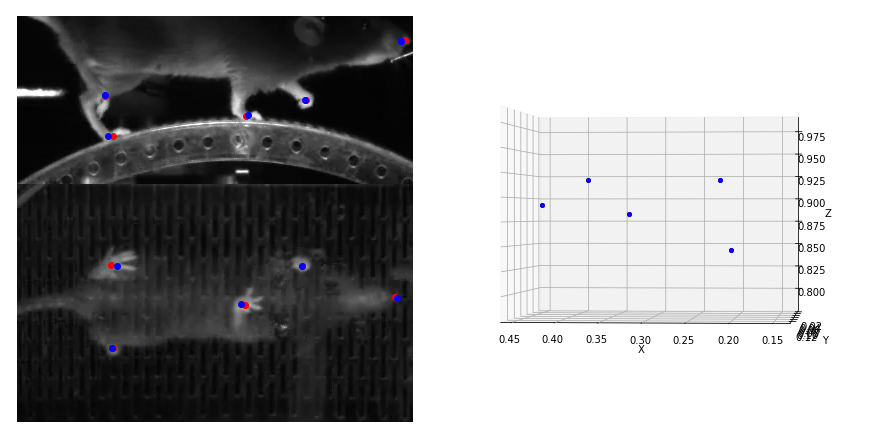

In [32]:
#### 3d plot
from matplotlib.gridspec import GridSpec
import mpl_toolkits.mplot3d.axes3d as p3
%matplotlib inline

fig = plt.figure(constrained_layout=True, figsize = (12,6))
gs = GridSpec(2, 2, figure=fig)
ax1 = fig.add_subplot(gs[:2, 0])
ax2 = fig.add_subplot(gs[:2, 1], projection = '3d') # https://matplotlib.org/3.1.1/gallery/mplot3d/subplot3d.html
image_folder = 'images_test'
if not os.path.exists(image_folder):
    os.makedirs(image_folder)

ax2.view_init(elev=0, azim=90) # see https://stackoverflow.com/questions/12904912/how-to-set-camera-position-for-3d-plots-using-python-matplotlib

#FRONT RIGHT PAW
for i in range(ind_start,ind_end):
    # clear both ax1 and ax2
    ax1.cla()
    ax2.cla()   
    # load image
    img_1 = read_image(path_images[0][i], flip=False)
    img_2 = read_image(path_images[1][i], flip=False)
    img = np.concatenate((img_1, img_2), axis=0)
    plot_image_labels(img,\
                        joined_list_2d,
                        i,
                        color_list_2d,
                        ax = ax1, top_img_height=TOP_IMG_HEIGHT)
    
    ax2.azim += 1
    plot_3d_points(joined_list_3d,
                   lims,
                   i,
                   color_list_3d,
                   ax=ax2)
    im_int = str('%.5i' % i)
    plt.savefig(image_folder + '/' + 'im' + im_int + '.png')


In [33]:
write_video(image_dir='./images_test/', out_file='reconstruction.mp4')

# Plot Bundle Adjusted Through Time

In [34]:
#Get axis lims
x_min = np.nanmin(BA_dict['x_coords'])
x_max = np.nanmax(BA_dict['x_coords'])
y_min = np.nanmin(BA_dict['y_coords'])
y_max = np.nanmax(BA_dict['y_coords'])
z_min = np.nanmin(BA_dict['z_coords'])
z_max = np.nanmax(BA_dict['z_coords'])
scene_lims = [[x_min,x_max], [y_min,y_max], [z_min,z_max]]

In [35]:
plot_dir = Path('./3d_point_plots/')
plot_dir.mkdir(exist_ok=True, parents=True)
for i in range(ind_start, ind_end):
    slice_3d = np.asarray([BA_dict['x_coords'][i], BA_dict['y_coords'][i],BA_dict['z_coords'][i]]).transpose()
    fig = plot_cams_and_points(points_3d=slice_3d, scene_lims=None, point_size=5, scene_aspect='cube', show_plot=False, title="3D Points Through Time")
    fig.write_image(str(plot_dir / f"points_{i}.png"))

In [36]:
write_video(image_dir=plot_dir, out_file="points_through_time.mp4")

# Plot Skeleton

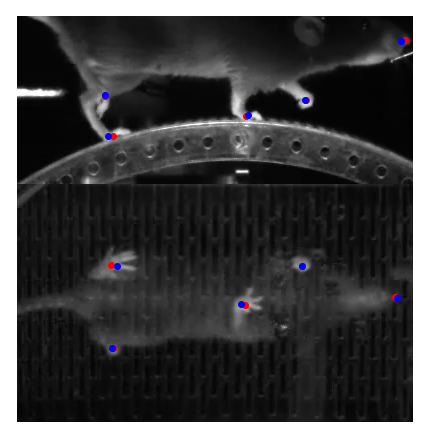

In [37]:
#### 3d plot
from matplotlib.gridspec import GridSpec

%matplotlib inline
plot_dir = Path('./3d_point_plots/')

fig = plt.figure(constrained_layout=True, figsize = (12,6))
gs = GridSpec(1, 1, figure=fig)
ax1 = fig.add_subplot(gs[:2, 0])
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)


for i in range(ind_start,ind_end):
    # clear both ax1 and ax2
    ax1.cla()
    # load image
    img_1 = read_image(path_images[0][i], flip=False)
    img_2 = read_image(path_images[1][i], flip=False)
    img = np.concatenate((img_1, img_2), axis=0)

    plot_image_labels(img,\
                        joined_list_2d,
                        i,
                        color_list_2d,
                        ax = ax1, top_img_height=TOP_IMG_HEIGHT)

    im_int = str('%.5i' % i)
    plt.savefig(str(plot_dir / ('im' + im_int + '.png')),bbox_inches='tight', pad_inches=0)

In [38]:
#['nose', 'paw1LH', 'paw2LF', 'paw3RF', 'paw4RH', 'tailBase', 'tailMid']
#0: nose
#1: left front paw
#2: left back paw
#3: right back paw
#4: right front
#5: tail base
#6: tail mid

In [39]:
#Plot skeleton
from PIL import Image

for i in range(ind_start, ind_end):
    im_int = str('%.5i' % i)
    proj_im_path = plot_dir / f"im{im_int}.png"
    proj_img = Image.open(proj_im_path)
    width, height = proj_img.size

    slice_3d = np.asarray([BA_dict['x_coords'][i], BA_dict['y_coords'][i],BA_dict['z_coords'][i]]).transpose()
    
    #Add coordinates of each bodypart to dict
    skeleton_bp = {}
    skeleton_bp['nose'] = (BA_dict['x_coords'][i][0], BA_dict['y_coords'][i][0], BA_dict['z_coords'][i][0])
    skeleton_bp['tail_base'] = (BA_dict['x_coords'][i][5], BA_dict['y_coords'][i][5], BA_dict['z_coords'][i][5])
    skeleton_bp['tail_mid'] = (BA_dict['x_coords'][i][6], BA_dict['y_coords'][i][6], BA_dict['z_coords'][i][6])
    #Draw vector from tail_base to tail_mid
    for index in range(1,5):
        skeleton_bp[f"paw_{index}"] = (BA_dict['x_coords'][i][index], BA_dict['y_coords'][i][index], BA_dict['z_coords'][i][index])

    #Now, define lines:
    #List of tuples indicating line from bodypart to bodypart, e.g. [('nose', 'tail_base')]
    #   draws a line from the nose to the base of the tail.
    #Also, to specify a midpoint, use a tuple in the tuple, e.g. [(('nose', 'tail_base'), 'paw_1')]
    #   draws a line from the midpoint of 'nose' and 'tail_base' to a paw.

    skeleton_lines = [('nose', 'tail_base'), ('tail_base', 'tail_mid')]
    #For each paw
    for index in range(1,5):
        #Draw a line from the midpoint of nose and tail_base to each paw
        skeleton_lines.append((('nose', 'tail_base'), f'paw_{index}'))


    #---------Plot 3D points with skeleton
    scene_camera = dict(
        up=dict(x=0, y=0, z=0),
        center=dict(x=0, y=0, z=0),
        eye=dict(x=0, y=-1, z=-2.5)
    )

    fig = plot_cams_and_points(points_3d=slice_3d, scene_lims=scene_lims, point_size=5, scene_aspect='cube',                                scene_camera=scene_camera, show_plot=False, title="3D Points Through Time", skeleton_bp=skeleton_bp,                                skeleton_lines=skeleton_lines)

    fig.write_image(str(plot_dir / f"3dpoints_{i}.png"), width=width, height=height)

    #--------------Now repeat, but include cameras in plot


    fig = plot_cams_and_points(cam_group=cam_group, points_3d=slice_3d, point_size=5, scene_aspect='cube',                                scene_camera=scene_camera, show_plot=False, title="3D Points Through Time", skeleton_bp=skeleton_bp,                                skeleton_lines=skeleton_lines)
    fig.update_traces(textfont_size=1)
    fig.write_image(str(plot_dir / f"3dpoints_cams_{i}.png"), width=width, height=height)



In [40]:
#Combine images
from pathlib import Path
from utils.utils_IO import read_image
import numpy as np
from PIL import Image

combined_dir = Path('./combined/')
combined_dir.mkdir(parents=True, exist_ok=True)
for i in range(ind_start,ind_end):
    im_int = str('%.5i' % i)
    proj_im_path = plot_dir / f"im{im_int}.png"
    proj_img = Image.open(proj_im_path)


    point_im_path = plot_dir / f"3dpoints_{i}.png"
    points_img = Image.open(point_im_path)

    cam_im_path = plot_dir / f"3dpoints_cams_{i}.png"
    cam_img = Image.open(cam_im_path)


    width, height = proj_img.size
    total_width = width * 3
    total_height = height

    new_im = Image.new('RGB', (total_width, total_height))

    x_offset = 0
    new_im.paste(proj_img, (0,0))
    new_im.paste(points_img, (width,0))
    new_im.paste(cam_img, (width * 2,0))

    new_im.save(str(combined_dir / f"combined_{i}.png"))

In [41]:
write_video(image_dir=combined_dir, out_file='combined.mp4')

# Epipolar Lines

In [42]:
ind_start = 155
ind_end = 255

In [43]:
from scipy.spatial.transform import Rotation as R
#Bundle adjustment code: https://scipy-cookbook.readthedocs.io/items/bundle_adjustment.html

# Get rotation vector
rot_vec_1 = R.from_rotvec(camera_1.get_rotation())
R1 = rot_vec_1.as_matrix()
print("R1: ", R1)
#Get translation vector
t1 = camera_1.get_translation()
print('t1: ', t1)

#Get intrinsic matrix
K1 = camera_1.get_camera_matrix()

# Get rotation vector
rot_vec_2 = R.from_rotvec(camera_2.get_rotation())
R2 = rot_vec_2.as_matrix()
print("R2: ", R2)
#Get translation vector
t2 = camera_2.get_translation()
print('t2: ', t2)

#Get intrinsic matrix
K2 = camera_2.get_camera_matrix()

# --- Now compute relevant quantities for F estimation ------
#Camera matrix basics: http://www.cs.cmu.edu/~16385/s17/Slides/11.1_Camera_matrix.pdf
#Fundamental matrix computation: https://rb.gy/dd0nz2

#Compute projection matrices
P1 = np.matmul(K1, np.concatenate((R1, t1[:, np.newaxis]), axis=1))
P2 = np.matmul(K2, np.concatenate((R2, t2[:, np.newaxis]), axis=1))

#Get camera center (view 1)
R1_inv = np.linalg.inv(R1) 
C = np.matmul(-R1_inv, t1)
C = np.append(C, 1)

F = np.matmul(skew(np.matmul(P2, C)), np.matmul(P2, np.linalg.pinv(P1)))
print('F: ', F)

R1:  [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
t1:  [-0.13783077 -0.01867244  0.38015666]
R2:  [[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.22044605e-16 -1.00000000e+00]
 [ 0.00000000e+00  1.00000000e+00  2.22044605e-16]]
t2:  [-0.12136012  0.99134757  1.29402967]
F:  [[-2.59995770e-17  1.35050177e+00  2.01423330e+03]
 [ 1.29260011e+00 -1.62184314e-02  5.02741672e-15]
 [-2.07223377e+03  2.38515949e-13 -3.87791259e+04]]


In [47]:
x_top = joined_list_2d[0]['x_coords'].ravel()[:,np.newaxis]
y_top = joined_list_2d[0]['y_coords'].ravel()[:,np.newaxis]

x_bot = joined_list_2d[1]['x_coords'].ravel()[:,np.newaxis]
y_bot = joined_list_2d[1]['y_coords'].ravel()[:,np.newaxis]

num_points = 20
pts1 = np.concatenate((x_top, y_top), axis=-1)[:num_points, :]
pts2 = np.concatenate((x_bot, y_bot), axis=-1)[:num_points, :]

F, mask = cv2.findFundamentalMat(pts1,pts2,cv2.FM_LMEDS)

In [48]:
epipolar_folder = './epipolar_lines/'
if not os.path.exists(epipolar_folder):
    os.makedirs(epipolar_folder)

for i in range(ind_start,ind_end):
    # load image
    top_img = (read_image(path_images[0][i], flip=False) * 255).astype(np.uint8)
    bottom_img = (read_image(path_images[1][i], flip=False) * 255).astype(np.uint8)

    #Recall, indices 0 and 2 correspond to bottom image
    x_t = joined_list_2d[0]['x_coords'][i][:,np.newaxis]
    y_t = joined_list_2d[0]['y_coords'][i][:,np.newaxis]

    x_b = joined_list_2d[1]['x_coords'][i][:,np.newaxis]
    y_b = joined_list_2d[1]['y_coords'][i][:,np.newaxis]

    points_top = np.concatenate((x_t,y_t), axis=1)
    points_bot = np.concatenate((x_b,y_b), axis=1)

    
    #Get rid of nans
    points_bot = points_bot.astype(np.int32)
    points_bot = points_bot[~np.isnan(points_bot).any(axis=1)]

    points_top = points_top.astype(np.int32)
    points_top = points_top[~np.isnan(points_top).any(axis=1)]


    top_img_with_points = draw_circles(top_img, points_top)
    bot_img_with_points = draw_circles(bottom_img, points_bot)
    #cv2.imwrite('epipolar_lines/top_image_points.jpg', top_img_with_points)
    #cv2.imwrite('epipolar_lines/bot_image_points.jpg', bot_img_with_points)

    #Homogenize points
    ones = np.ones(points_top.shape[0])[:,np.newaxis]
    points_top_homog = np.concatenate((points_top, ones), axis=-1)
    points_bot_homog = np.concatenate((points_bot, ones), axis=-1)
    
    aug_F = np.tile(F, (points_top_homog.shape[0], 1, 1))
    lines_bot = np.squeeze(np.matmul(aug_F, points_top_homog[:,:,np.newaxis]))
    #This^ gives us lines as vectors [a,b,c] --> ax + by + c = 0

    for line_vec in lines_bot:
        #Get x and y intercepts (on image) to plot
        #y = 0: x = -c/a
        x_intercept = int(-line_vec[2] / line_vec[0])
        #x = 0: y = -c/b
        y_intercept = int(-line_vec[2] / line_vec[1])
        bottom_img = drawLine(bottom_img, x_intercept, 0, 0, y_intercept)
        #bottom_img = cv2.line(bottom_img, (x_intercept, 0), (0, y_intercept), (255, 255, 255), thickness=1)

    final_img = cv2.vconcat([top_img, bottom_img])
    cv2.imwrite(f'epipolar_lines/{i}.jpg', final_img)

In [46]:
write_video(image_dir=epipolar_folder, out_file="epipolar_video.mp4")

# Undistorting